In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split
import optuna
from catboost import CatBoostRegressor as cbr

/Users/evidentbackend/.local/share/virtualenvs/mye-order-prediction-service-R-2NzdQ6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Load Dataset
df = pd.read_csv('dataset.csv')
df

,timestamp,orders
0,2023-12-05,801
1,2023-12-04,1677
2,2023-12-03,862
3,2023-12-02,116
4,2023-12-01,840
...,...,...
632,2022-03-06,412
633,2022-03-05,64
634,2022-03-04,288
635,2022-03-03,136


In [5]:

# Assuming df is your DataFrame with a 'timestamp' column
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Create lag features (e.g., lag 1 and lag 2)
df['lag_1'] = df['orders'].shift(1)
df['lag_2'] = df['orders'].shift(2)
df = df.set_index("timestamp")


In [7]:
X = df[['month','day','day_of_week','lag_1','lag_2']]  # Select relevant features
y = df['orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [5]:
X_train

,month,day,day_of_week,lag_1,lag_2
timestamp,,,,,
2022-03-01,3,1,1,NaN,NaN
2022-03-02,3,2,2,94.0,NaN
2022-03-03,3,3,3,228.0,94.0
2022-03-04,3,4,4,615.0,228.0
2022-03-05,3,5,5,620.0,615.0
...,...,...,...,...,...
2023-03-23,3,23,3,1117.0,1080.0
2023-03-24,3,24,4,1062.0,1117.0
2023-03-25,3,25,5,1073.0,1062.0


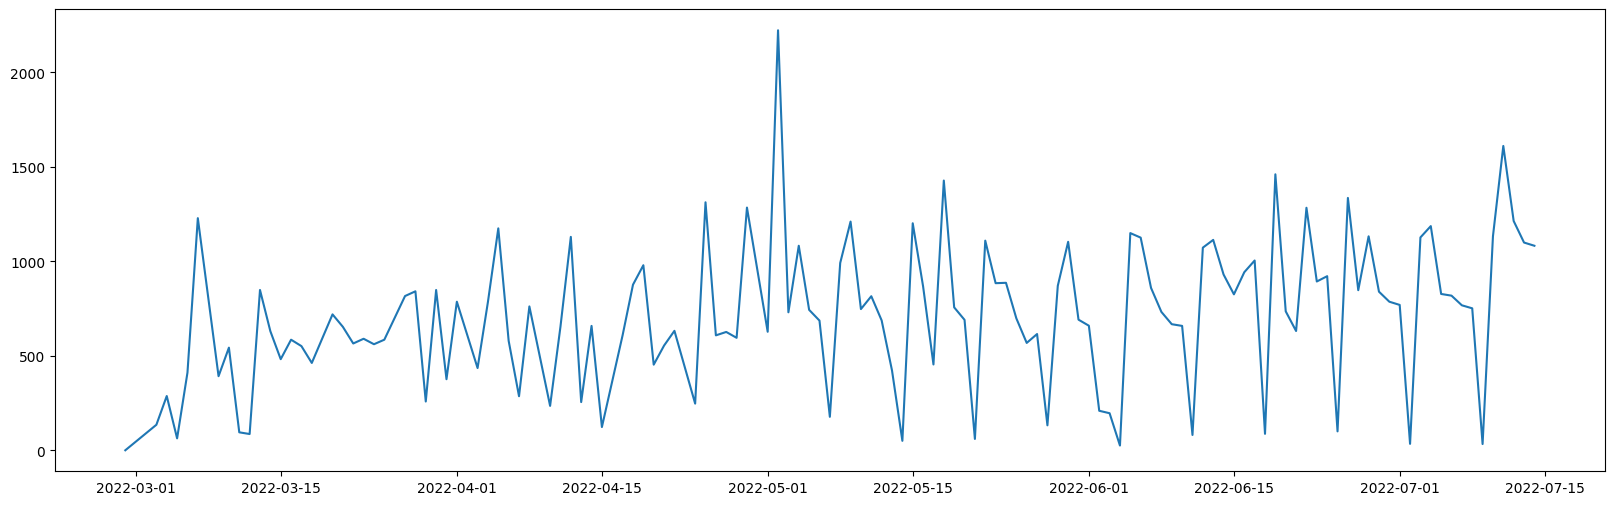

In [10]:
plt.figure(figsize=(20, 6))
plt.plot(y_test)
plt.show()

In [15]:
def objective(trial):
    params = {
        "iterations": 50000,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.10, 0.50),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
    }

    model = cbr(**params, silent=True)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    return r2

In [17]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-09-28 10:21:39,132] A new study created in memory with name: no-name-ee2859e9-8f0c-4ca6-947a-95e1e987f45f
[I 2023-09-28 10:21:56,862] Trial 0 finished with value: 0.40923451730916793 and parameters: {'learning_rate': 0.003576809152246922, 'depth': 3, 'subsample': 0.3872292994470313, 'colsample_bylevel': 0.769025580312891, 'min_data_in_leaf': 94}. Best is trial 0 with value: 0.40923451730916793.
[I 2023-09-28 10:22:47,188] Trial 1 finished with value: 0.3829288783044841 and parameters: {'learning_rate': 0.0018889496043885652, 'depth': 7, 'subsample': 0.17669818196024828, 'colsample_bylevel': 0.5515384434439548, 'min_data_in_leaf': 73}. Best is trial 0 with value: 0.40923451730916793.
[I 2023-09-28 10:25:39,384] Trial 2 finished with value: 0.3809722228203103 and parameters: {'learning_rate': 0.0016163130692538317, 'depth': 9, 'subsample': 0.395822960475796, 'colsample_bylevel': 0.900849219824952, 'min_data_in_leaf': 26}. Best is trial 0 with value: 0.40923451730916793.
[I 2023-0

In [18]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.002226831972356923, 'depth': 2, 'subsample': 0.20048813477340174, 'colsample_bylevel': 0.6460307677656545, 'min_data_in_leaf': 63}
Best RMSE: 0.46297819799356377


In [11]:
best = {'learning_rate': 0.002226831972356923, 'depth': 2, 'subsample': 0.20048813477340174, 'colsample_bylevel': 0.6460307677656545, 'min_data_in_leaf': 63}
best_result_1 = {'learning_rate': 0.019503677779003074, 'depth': 2, 'subsample': 0.11754531824810734, 'colsample_bylevel': 0.908697097509619, 'min_data_in_leaf': 89}
best_reuslt_2 = {'learning_rate': 0.0016521591626272969, 'depth': 2, 'subsample': 0.3900221809880413, 'colsample_bylevel': 0.7254443677762801, 'min_data_in_leaf': 12}
best_result_3 = {'learning_rate': 0.0011299005252711873, 'depth': 2, 'subsample': 0.3396960663915695, 'colsample_bylevel': 0.7849885386183735, 'min_data_in_leaf': 28}

In [ ]:
model = cbr(
    **best,
    iterations=50000,
    loss_function='RMSE',
    cat_features=['month', 'day_of_week'],
)

# Train the model using X_train and y_train
model.fit(X_train, y_train)

0:	learn: 363.4801465	total: 74.4ms	remaining: 1h 2m 1s
1:	learn: 363.1121252	total: 75.9ms	remaining: 31m 36s
2:	learn: 362.7357719	total: 76.8ms	remaining: 21m 19s
3:	learn: 362.3182419	total: 77.4ms	remaining: 16m 7s
4:	learn: 361.9512328	total: 77.8ms	remaining: 12m 57s
5:	learn: 361.7677497	total: 78.6ms	remaining: 10m 54s
6:	learn: 361.3272818	total: 79ms	remaining: 9m 23s
7:	learn: 360.9116805	total: 79.5ms	remaining: 8m 16s
8:	learn: 360.8749903	total: 80ms	remaining: 7m 24s
9:	learn: 360.5042147	total: 80.6ms	remaining: 6m 43s
10:	learn: 360.2098113	total: 81.1ms	remaining: 6m 8s
11:	learn: 359.7923908	total: 81.7ms	remaining: 5m 40s
12:	learn: 359.4623899	total: 82.1ms	remaining: 5m 15s
13:	learn: 359.1398591	total: 82.6ms	remaining: 4m 54s
14:	learn: 358.7266595	total: 83.2ms	remaining: 4m 37s
15:	learn: 358.3301129	total: 83.6ms	remaining: 4m 21s
16:	learn: 357.9478716	total: 84ms	remaining: 4m 6s
17:	learn: 357.5444093	total: 84.5ms	remaining: 3m 54s
18:	learn: 357.1688803

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# Assuming y_actual and y_pred are your actual and predicted values
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared (R²): {r2}")

In [ ]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df['timestamp'] = y_test.index
y_pred_df = y_pred_df.set_index('timestamp')
y_pred_df

In [ ]:
np.random.seed(42)
time = pd.date_range(start="2023-07-05", periods=90, freq="D")
data = np.cumsum(np.random.randn(90))  # Random walk

test_df = pd.DataFrame({'timestamp': time})
test_df.reset_index()

test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df['year'] = test_df['timestamp'].dt.year
test_df['month'] = test_df['timestamp'].dt.month
test_df['day'] = test_df['timestamp'].dt.day
test_df['day_of_week'] = test_df['timestamp'].dt.dayofweek
test_df['lag_1'] = np.nan
test_df['lag_2'] = np.nan
test_df.set_index('timestamp', inplace=True)

test_df

In [ ]:

# Predict for the specified time period
prediction_2 = model.predict(test_df)
y_pred2_df = pd.DataFrame(prediction_2)
y_pred2_df['timestamp'] = test_df.index
y_pred2_df = y_pred2_df.set_index('timestamp')
y_pred2_df

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(y_test)
plt.plot(y_pred_df, color='red')
plt.plot(y_pred2_df, color='green')
plt.show()

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(y_pred2_df, color='red')
plt.show()

In [ ]:
model.feature_importances_
model.get_feature_names()

In [ ]:
pd.DataFrame({'feature_importance': model.feature_importances_, 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)